In [1]:
"""
Magic commands
"""
%matplotlib inline
%load_ext autoreload
%autoreload 2

"""
Python standard packages
"""
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

"""
Own packages
"""
sys.path.insert(0, "C:\\code\\speciale\\") # vesl path
sys.path.insert(0, "C:\\Users\\lucas\\OneDrive\\Skrivebord\\repo\\speciale\\") # ljb path

from temp.agent_rl import RandomAgent, InvestorAgent, TrendAgent, RLAgent
from market_simulation_study.environment import MarketEnvironment


# Simulation 


## Setup

In [34]:
# Declare parameters
n_random_agents= 20
n_investor_agents = 2
n_trend_agents = 5
n_rl_agents = 1

n_agents = n_random_agents + n_investor_agents + n_trend_agents + n_rl_agents


time_periods = 30000

price_list = [100 + np.random.normal() for j in range(100)]
ex_list = np.array([[0]*n_agents, [0]*n_agents])
fee = 0
mean_buy_price = 99
mean_sell_price = 101

state0 = {"market_prices": price_list, "execution_status": ex_list, 'fee':fee, "mean_buy_price":mean_buy_price,
          "mean_sell_price":mean_sell_price}

env = MarketEnvironment(state0)
agents = []

random_agents = [RandomAgent(agent_id = j,
                             latency = np.random.normal()) for j in range(n_random_agents)]

investor_agents = [InvestorAgent(agent_id = j + n_random_agents,
                                 latency = np.random.normal(),
                                 intensity = 0.1) for j in range(n_investor_agents)]

trend_agents = [TrendAgent(agent_id = j + n_random_agents + n_investor_agents,
                                 latency = np.random.normal()) for j in range(n_trend_agents)]

rl_agents = [RLAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents,
                                 latency = np.random.normal()) for j in range(n_rl_agents)]

agents.append(random_agents)
agents.append(investor_agents)
agents.append(trend_agents)
agents.append(rl_agents)

agents = [item for sublist in agents for item in sublist]

# Initialize agents
for j in range(n_agents):
        agents[j].update(state0)

## Run simulation

In [35]:
#fig, ax = plt.subplots(figsize = (12, 6))
#plot_data = pd.DataFrame({"time": None, "pnl": None, "agent_id": None}, index = [0])
rl_profit = []
for time in range(time_periods):
    state = env.step(agents)
    agents[-1].calculate_profit_and_loss(state)
    rl_profit.append(agents[-1].pnl)
    agents[-1].update_q_mat(state)
    for j in range(n_agents):
        agents[j].update(state)
        #agents[j].calculate_profit_and_loss(state)
        #ax.scatter(time, agents[j].pnl)
        


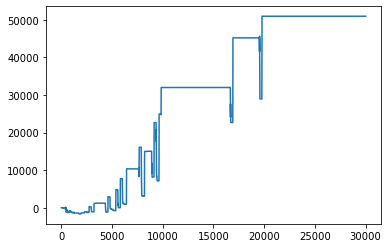

In [36]:
plt.plot(rl_profit)

# Performance overview

In [40]:
ma = pd.Series(state["market_prices"]).rolling(window = 1).apply(lambda x: np.average(x)).dropna()
ma2 = pd.Series(state["market_prices"]).rolling(window = 2).apply(lambda x: np.average(x)).dropna()


713.5896649188086

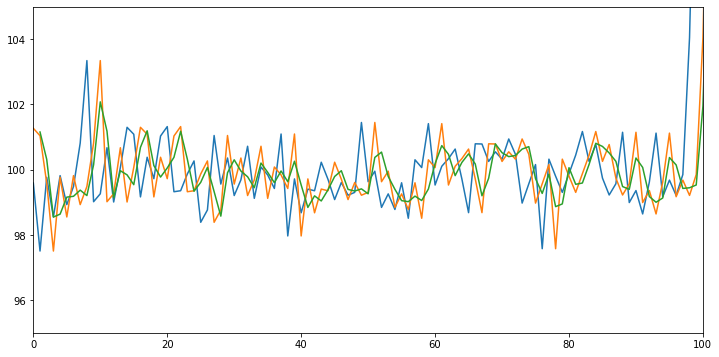

In [51]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(state['market_prices'][2:])
ax.plot(ma)
ax.plot(ma2)
ax.set(xlim=[0,100])
ax.set(ylim=[95,105])
state["market_prices"]
np.maximum(agents[0].sell_price, 0)

In [39]:
np.asarray(agents[-1].q_mat).round()

array([[18656., 18656., 18656.],
       [12105., 12803., 21078.]])

In [24]:
stats_df[stats_df["class"] == "Random"]["PNL"].sum()

-678.1687093904435

In [25]:
stats_df[stats_df["class"] == "Investor"]["PNL"].sum()

3307.255405963805

In [26]:
stats_df[stats_df["class"] == "Investor"]["Position"].sum()

98.0

In [27]:
stats_df[stats_df["class"] == "Random"]["Position"].sum()

0.0

In [13]:
stats_df = pd.DataFrame({"id":None, "class":None, "Position":None, "PNL":None}, index = [0]).dropna()
for agent in agents:
    agent.calculate_profit_and_loss(state)
    df_temp = pd.DataFrame({"id": agent.agent_id,
                            "class":agent.agent_class, 
                            "Position":agent.position, 
                            "PNL": agent.pnl, 
                            "latency": agent.latency},
                            index = [agent.agent_id])
    stats_df = stats_df.append(df_temp)

print("PNL SUM: ", stats_df["PNL"].sum())
print("POS SUM: ", stats_df["Position"].sum())
stats_df.sort_values("latency", inplace = True)
np.corrcoef(stats_df.PNL.values, stats_df.latency.values)
display(stats_df)
display(stats_df.groupby("class")["PNL"].mean())

PNL SUM:  535.044607355976
POS SUM:  0.0


,id,class,Position,PNL,latency
24,24,Random,-3.0,2442.742934,-2.157313
31,31,Investor,20.0,1679.174047,-1.617220
4,4,Random,13.0,1319.301157,-1.462068
10,10,Random,-49.0,1588.360679,-1.320166
11,11,Random,-5.0,1639.797627,-1.301046
30,30,Investor,20.0,1383.577349,-1.297824
26,26,Random,-51.0,-333.530622,-1.236449
18,18,Random,-56.0,1534.933876,-0.918689
0,0,Random,-22.0,288.072879,-0.833829
32,32,Investor,20.0,1559.803209,-0.650389


class
Investor    1354.516333
RL         -2427.137078
Random       190.116521
Trend       -951.389561
Name: PNL, dtype: float64